###### dataset: https://www.kaggle.com/datasets/prajwaldongre/nvidia-corp-share-price-2000-2024

In [1]:
# load those needed libraries and packages
import torch
import optuna
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the nvidia stock price dataset
nvidia_df = pd.read_csv('nvidia_stock_price.csv')

/Users/ngkokteng/PycharmProjects/NVIDIA stock prediction/.venv/lib/python3.9/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


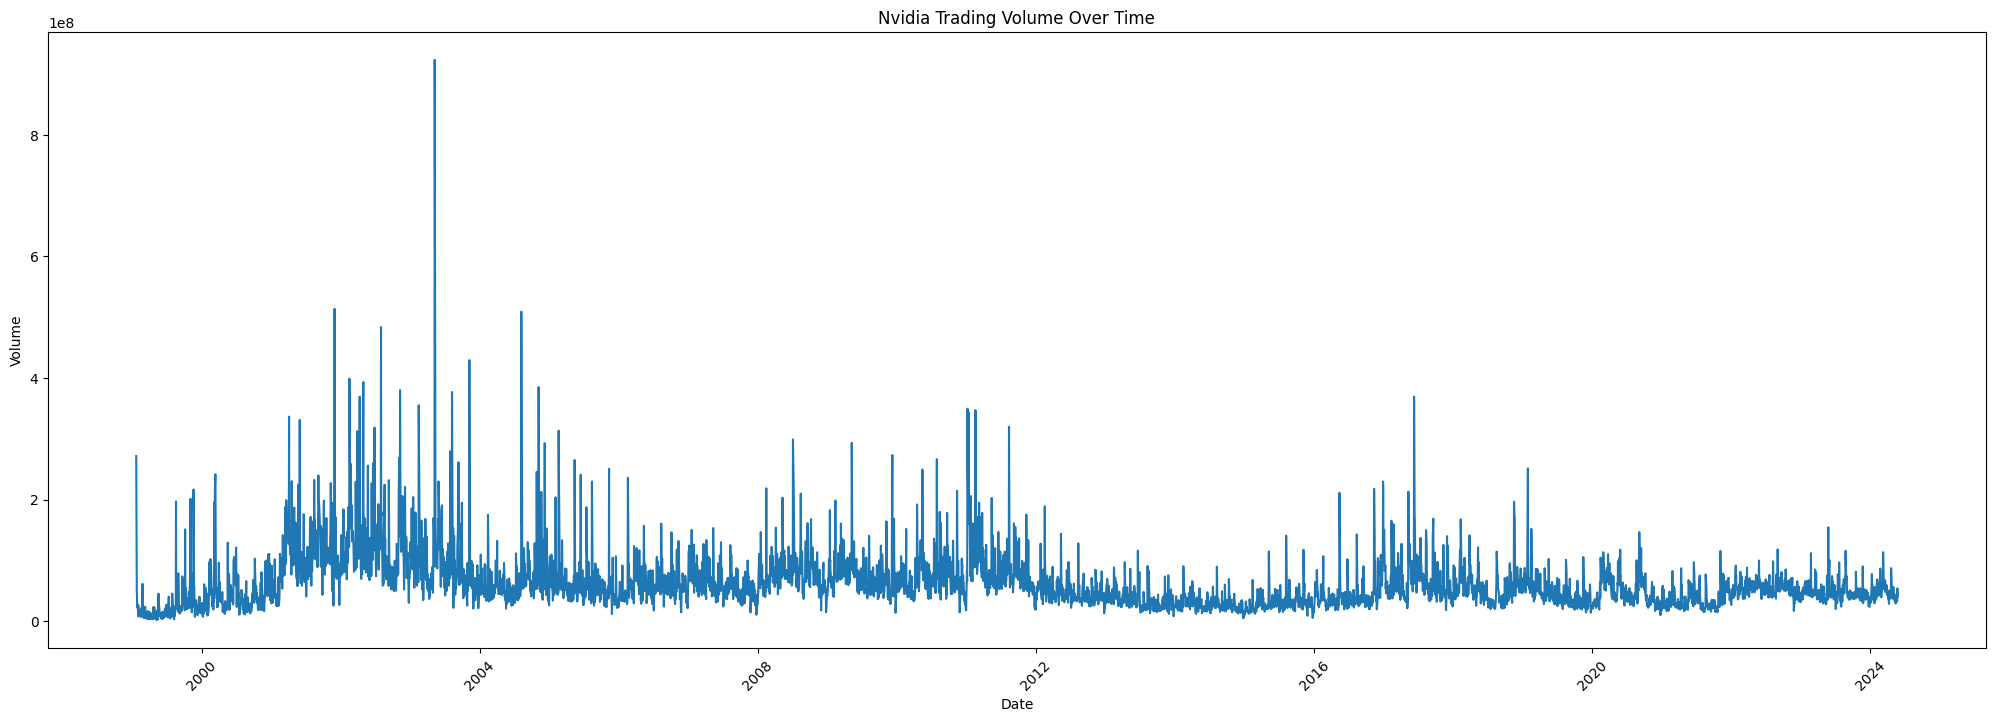

In [2]:
# convert the "Date" column to datetime format
nvidia_df["Date"] = pd.to_datetime(nvidia_df["Date"])

plt.figure(figsize = (25, 8))
plt.plot(nvidia_df["Date"], nvidia_df["Volume"])
plt.title("Nvidia Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")

# get the current axes
ax = plt.gca() 
# set the major locator to YearLocator with base 4
ax.xaxis.set_major_locator(mdates.YearLocator(base = 4))
# set the major formatter to DateFormatter with format '%Y'
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation = 45)
plt.show()

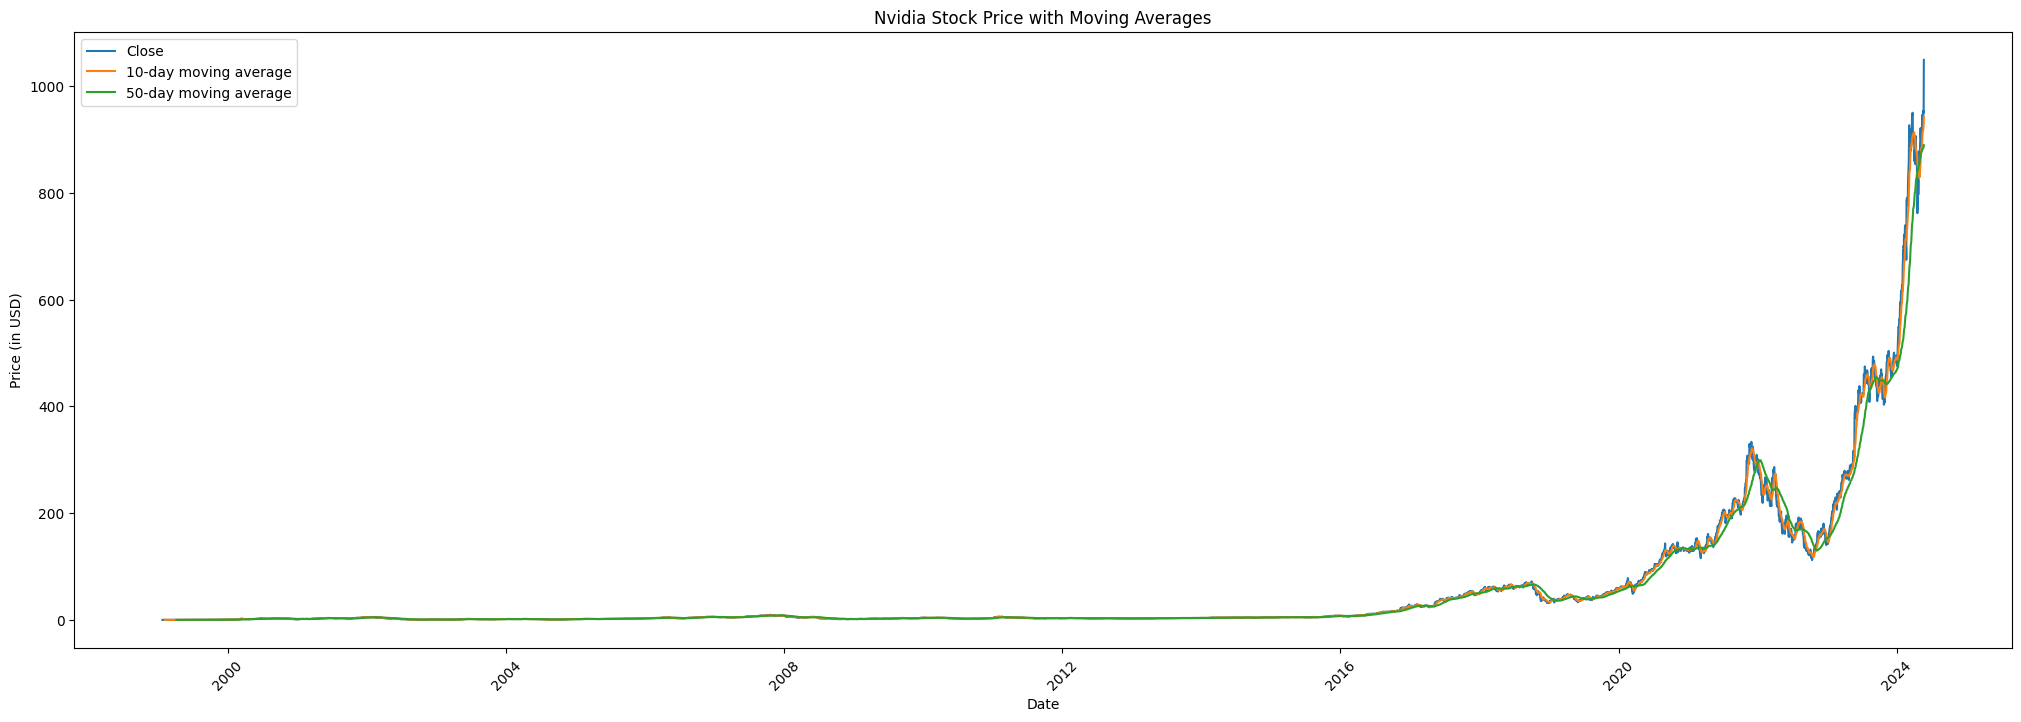

In [3]:
# 10-day moving average
nvidia_df["MA10"] = nvidia_df["Close"].rolling(window = 10).mean()
# 50-day moving average
nvidia_df["MA50"] = nvidia_df["Close"].rolling(window = 50).mean()

plt.figure(figsize = (25, 8))
plt.plot(nvidia_df["Date"], nvidia_df["Close"], label = "Close")
plt.plot(nvidia_df["Date"], nvidia_df["MA10"], label = "10-day moving average")
plt.plot(nvidia_df["Date"], nvidia_df["MA50"], label = "50-day moving average")
plt.title("Nvidia Stock Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (in USD)")
plt.legend(loc = "best")

# format x-ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base = 4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation = 45)
plt.show()

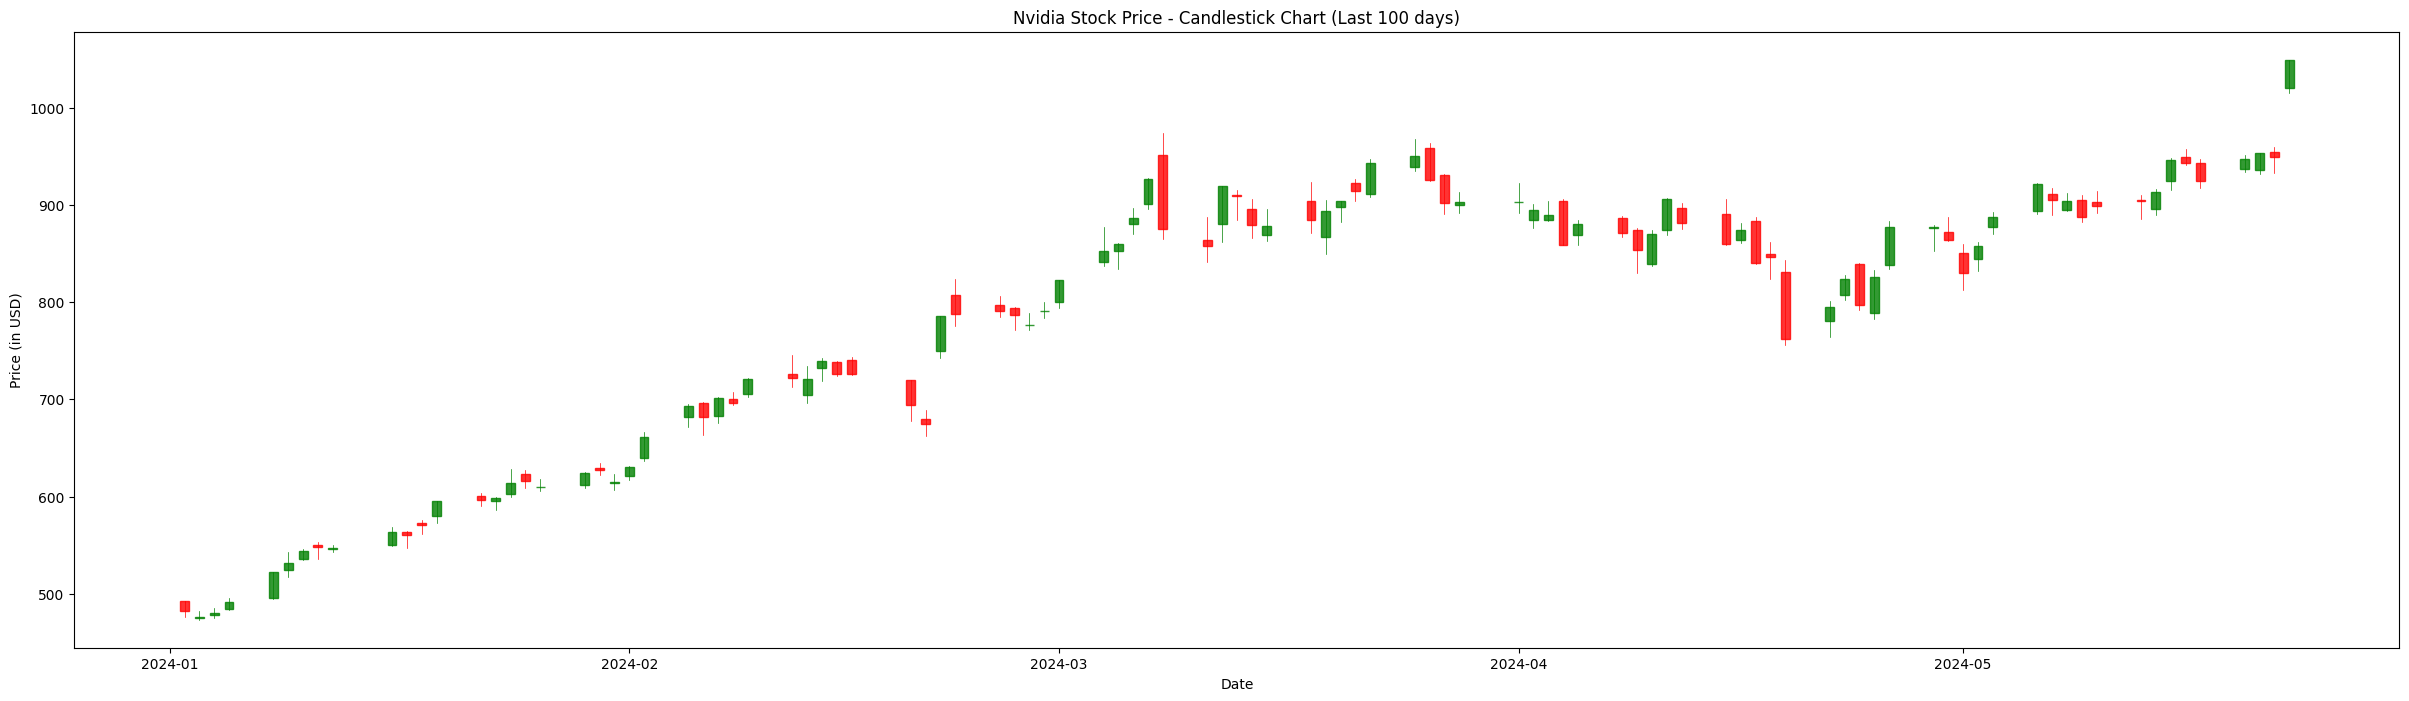

In [4]:
# plot the candlestick chart for the last 100 days
# get the last 100 rows of the dataframe
nvidia_df_last_100 = nvidia_df[-100:].copy()
# convert the "Date" column to matplotlib date format
nvidia_df_last_100["Date"] = nvidia_df_last_100["Date"].map(mdates.date2num)
# get the values of the "Date", "Open", "High", "Low", and "Close" columns
ohlc = nvidia_df_last_100[["Date", "Open", "High", "Low", "Close"]].values

fig, ax = plt.subplots(figsize = (30, 8))
# plot the candlestick chart
candlestick_ohlc(ax, ohlc, width = 0.6, colorup = "green", colordown = "red", alpha = 0.8)
# set the x-axis to display dates
ax.xaxis_date()
plt.title("Nvidia Stock Price - Candlestick Chart (Last 100 days)")
plt.xlabel("Date")
plt.ylabel("Price (in USD)")
plt.show()

In [ ]:
nvidia_df["Date"] = pd.to_datetime(nvidia_df["Date"])
nvidia_df["Date"] = nvidia_df["Date"].apply(mdates.date2num)
ohlc = nvidia_df[["Date", "Open", "High", "Low", "Close"]].values
fig, ax = plt.subplots(figsize = (30, 8))
candlestick_ohlc(ax, ohlc, width = 0.6, colorup = "green", colordown = "red", alpha = 0.8)
ax.xaxis_date()
plt.title("Nvidia Stock Price - Candlestick Chart")
plt.xlabel("Date")
plt.ylabel("Price (in USD)")
plt.show()

###### Predicting Stock Prices with Linear Regression Model (and Moving Averages)

In [ ]:
# add a new column "Price_Up" to the dataframe
nvidia_df["Price_Up"] = np.where(nvidia_df["Close"].shift(-1) > nvidia_df["Close"], 1, 0)
# shift the "Price_Up" column by 1 row
nvidia_df["Price_Up"] = nvidia_df["Price_Up"].shift(-1)
nvidia_df = nvidia_df.dropna()
X = nvidia_df[["Date", "Close", "Volume", "MA10", "MA50"]]
y = nvidia_df["Close"]

# split dataset into 60% training, 20% validation, and 20% testing
train_split = int(0.65 * len(nvidia_df))
val_split = int(0.9 * len(nvidia_df))

X_train = X[:train_split]
X_val = X[train_split:val_split]
X_test = X[val_split:]
y_train = y[:train_split]
y_val = y[train_split:val_split]
y_test = y[val_split:]

# train a linear regression model
lr = LinearRegression()
lr.fit(X_train.drop("Date", axis = 1), y_train)

# make predictions on the validation set
y_val_pred = lr.predict(X_val.drop("Date", axis = 1))
y_val_pred = pd.Series(y_val_pred, index = y_val.index)
# calculate the mean squared error on the validation set
mse_val = mean_squared_error(y_val, y_val_pred)
print("Validation Mean Squared Error: {}".format(mse_val))

# make predictions on the test set
y_test_pred = lr.predict(X_test.drop("Date", axis = 1))
y_test_pred = pd.Series(y_test_pred, index = y_test.index)
# calculate the mean squared error on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
print("Test Mean Squared Error: {}".format(mse_test))

In [ ]:
# plot the actual, predicted, and validation prices along with the moving averages
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (25, 16), sharex = True)

# plot for the 10-day moving average
ax1.scatter(X_test["Date"], y_test.values, label = "Actual", color = "purple")
ax1.scatter(X_val["Date"], y_val.values, label = "Actual", color = "purple")
ax1.plot(X_test["Date"], y_test_pred.values, label = "Predicted", color = "green")
ax1.plot(X_val["Date"], y_val_pred.values, label = "Validation", color = "orange")
ax1.plot(nvidia_df["Date"], nvidia_df["MA10"], label="10-day moving average", color = "blue")
ax1.set_title("10-day Moving Average vs Actual, Predicted and Validation Prices")
ax1.set_ylabel("Price (in USD)")
ax1.legend(loc = "best")
ax1.grid(True)

# plot for the 50-day moving average
ax2.scatter(X_test["Date"], y_test.values, label = "Actual", color = "purple")
ax2.scatter(X_val["Date"], y_val.values, label = "Actual", color = "purple")
ax2.plot(X_test["Date"], y_test_pred.values, label = "Predicted", color = "green")
ax2.plot(X_val["Date"], y_val_pred.values, label = "Validation", color = "orange")
ax2.plot(nvidia_df["Date"], nvidia_df["MA50"], label = "50-day moving average", color = "red")
ax2.set_title("50-day Moving Average vs Actual, Predicted and Validation Prices")
ax2.set_xlabel("Date")
ax2.set_ylabel("Price (in USD)")
ax2.legend(loc="best")
ax2.grid(True)

fig.autofmt_xdate()
ax1.xaxis.set_major_locator(mdates.YearLocator(base=4))
ax2.xaxis.set_major_locator(mdates.YearLocator(base=4))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

###### Using deep learning to predict stock prices

In [ ]:
# define a class called StockPriceLSTM that inherits from nn.Module
class StockPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(StockPriceLSTM, self).__init__()
        # initialize the hidden layer size
        self.hidden_layer_size = hidden_layer_size
        # create an LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True).to(device)
        # create a layer normalization layer
        self.layernorm = nn.LayerNorm(hidden_layer_size).to(device)
        # create a linear layer
        self.linear = nn.Linear(hidden_layer_size, output_size).to(device)

    # define the forward method
    def forward(self, input_seq):
        # get the batch size
        batch_size = input_seq.size(0)
        # initialize the hidden cell
        hidden_cell = self.init_hidden(batch_size)
        # pass the input sequence through the LSTM layer
        lstm_out, hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1).to(device), hidden_cell)
        # apply layer normalization to the output of the LSTM layer
        lstm_out = self.layernorm(lstm_out[:,-1,:])
        # pass the output of the LSTM layer through the linear layer
        predictions = self.linear(lstm_out)
        return predictions.flatten()

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_layer_size).to(device),
                torch.zeros(1, batch_size, self.hidden_layer_size).to(device))

In [ ]:
# define a function called train_epoch that takes in the model, train_loader, criterion, and optimizer as input
def train_epoch(model, train_loader, criterion, optimizer):
    # set the model to training mode
    model.train()
    # initialize the total loss to 0
    total_loss = 0
    # iterate over the train_loader
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [ ]:
# define a function called flat_accuracy that takes in the predictions and labels as input
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# define a function called eval_model that takes in the model, test_loader, and criterion as input
def eval_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    for inputs, targets in test_loader:
        output = model(inputs)
        loss = criterion(output, targets)
        total_loss += loss.item()
    return total_loss / len(test_loader)

In [ ]:
# Define the objective function for the Optuna study
def objective(trial):
    # Suggest a value for the hidden layer size between 1 and 100
    hidden_layer_size = trial.suggest_int("hidden_layer_size", 1, 100)
    # Suggest a value for the learning rate between 1e-5 and 1e-1
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1)
    # Suggest a value for the batch size between 1 and 32
    batch_size = trial.suggest_int("batch_size", 1, 32)
    # Suggest a value for the number of epochs between 50 and 2000
    num_epochs = trial.suggest_int("num_epochs", 50, 2000)

    # Initialize the LSTM model with the suggested parameters
    model = StockPriceLSTM(5, hidden_layer_size, 1).to(device)
    # Define the loss function as Mean Squared Error (MSE)
    criterion = nn.MSELoss()
    # Define the optimizer as AdamW with the suggested learning rate
    optimizer = AdamW(model.parameters(), lr = learning_rate)
    # Define the learning rate scheduler as StepLR with step size 1 and gamma 0.7
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.7)

    # Prepare the training dataset and loader
    train_dataset = TensorDataset(torch.tensor(X_train.values).float().to(device), torch.tensor(y_train.values).float().to(device))
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

    # Prepare the validation dataset and loader
    val_dataset = TensorDataset(torch.tensor(X_val.values).float().to(device), torch.tensor(y_val.values).float().to(device)) 
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

    # Train the model for the suggested number of epochs
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        scheduler.step()
    # Evaluate the model on the validation set
    val_loss = eval_model(model, val_loader, criterion)
    return val_loss

# Create an Optuna study that aims to minimize the objective function
study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 25)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))